In [1]:
# 1. Setup and Load Data
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
# import catboost as cb # Uncomment if you want to use CatBoost
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's pipeline for SMOTE integration

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [3]:
# Load the dataset
# IMPORTANT: Replace 'online_retail_customer_churn.csv' with the actual path to your dataset
try:
    df = pd.read_csv('online_retail_customer_churn.csv') # Example filename for Online Retail
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'data/online_retail_churn.csv' (or your file) is in the 'data/' directory.")
    exit() # Exit if dataset isn't found for a cleaner run

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset loaded successfully!

First 5 rows of the dataset:
   Customer_ID  Age Gender  Annual_Income  Total_Spend  Years_as_Customer  \
0            1   62  Other          45.15      5892.58                  5   
1            2   65   Male          79.51      9025.47                 13   
2            3   18   Male          29.19       618.83                 13   
3            4   21  Other          79.63      9110.30                  3   
4            5   21  Other          77.66      5390.88                 15   

   Num_of_Purchases  Average_Transaction_Amount  Num_of_Returns  \
0                22                      453.80               2   
1                77                       22.90               2   
2                71                       50.53               5   
3                33                      411.83               5   
4                43                      101.19               3   

   Num_of_Support_Contacts  Satisfaction_Score  Last_Purchase_Days_Ago  \
0

In [4]:
# Display dataset info
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer_ID                 1000 non-null   int64  
 1   Age                         1000 non-null   int64  
 2   Gender                      1000 non-null   object 
 3   Annual_Income               1000 non-null   float64
 4   Total_Spend                 1000 non-null   float64
 5   Years_as_Customer           1000 non-null   int64  
 6   Num_of_Purchases            1000 non-null   int64  
 7   Average_Transaction_Amount  1000 non-null   float64
 8   Num_of_Returns              1000 non-null   int64  
 9   Num_of_Support_Contacts     1000 non-null   int64  
 10  Satisfaction_Score          1000 non-null   int64  
 11  Last_Purchase_Days_Ago      1000 non-null   int64  
 12  Email_Opt_In                1000 non-null   bool   
 13  Promotion_Re

In [5]:
# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
       Customer_ID          Age  Annual_Income  Total_Spend  \
count  1000.000000  1000.000000    1000.000000   1000.00000   
mean    500.500000    43.267000     111.962960   5080.79265   
std     288.819436    15.242311      52.844111   2862.12335   
min       1.000000    18.000000      20.010000    108.94000   
25%     250.750000    30.000000      67.800000   2678.67500   
50%     500.500000    43.000000     114.140000   4986.19500   
75%     750.250000    56.000000     158.452500   7606.47000   
max    1000.000000    69.000000     199.730000   9999.64000   

       Years_as_Customer  Num_of_Purchases  Average_Transaction_Amount  \
count        1000.000000       1000.000000                 1000.000000   
mean            9.727000         49.456000                  266.876530   
std             5.536346         28.543595                  145.873445   
min             1.000000          1.000000                   10.460000   
25%             5.000000         25.000000 

In [6]:
# Check for missing values
print("\nMissing values before preprocessing:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values before preprocessing:
Series([], dtype: int64)


In [7]:
# --- Specific adjustments for Online Retail Dataset ---
# Handle CustomerID column if present
if 'Customer_ID' in df.columns:
    df = df.drop('Customer_ID', axis=1)
    print("Dropped 'Customer_ID' column.")

Dropped 'Customer_ID' column.


In [8]:
# Handle transactional columns if the dataset is raw transaction data rather than aggregated customer data
# If your dataset contains columns like 'InvoiceNo', 'StockCode', 'Description', 'Quantity',
# 'InvoiceDate', 'UnitPrice', 'Country', you might need to aggregate it first to customer-level data.
# For simplicity, assuming the dataset is already aggregated to a customer-level view with churn status.
# If not, you'd perform RFM (Recency, Frequency, Monetary) analysis here to create core features.
# Example: If 'DaysSinceLastPurchase' is not present, you'd calculate Recency.
# Example: If 'TotalSpend' is not present, you'd sum 'Quantity' * 'UnitPrice' per customer.
# Example: Handle missing values in numerical columns like 'DaysSinceLastPurchase' or 'TotalSpend'
# For new customers, these might be NaN. Filling with 0 or mean/median could be options.
# Assuming 'DaysSinceLastPurchase' and 'TotalSpend' are key numerical features that might have NaNs
for col in ['DaysSinceLastPurchase', 'TotalSpend', 'NumPurchases', 'AvgItemValue', 'SatisfactionScore']:
    if col in df.columns and df[col].isnull().any():
        print(f"Missing values in '{col}'. Filling with 0 (assuming new customers or no activity).")
        df[col].fillna(0, inplace=True) # Or df[col].median() if more appropriate

print("\nMissing values after initial handling:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values after initial handling:
Series([], dtype: int64)


In [9]:
# Convert target variable to numerical (0/1)
# Assuming 'Churn' column with 'No'/'Yes' values
# Adjust 'Churn' to your actual target column name if different (e.g., 'is_churned')
target_column_name = 'Target_Churn' # Change this if your churn column is named differently
if target_column_name in df.columns:
    if df[target_column_name].dtype == 'object':
        unique_churn_values = df[target_column_name].unique()
        if 'TRUE' in unique_churn_values and 'FALSE' in unique_churn_values:
            df[target_column_name] = df[target_column_name].map({'FALSE': 0, 'TRUE': 1})
            print(f"'{target_column_name}' column mapped to 0/1.")
        elif 1 in unique_churn_values and 0 in unique_churn_values:
            print(f"'{target_column_name}' column is already 0/1 numerical.")
        else:
            print(f"Warning: '{target_column_name}' column has unexpected values: {unique_churn_values}. Please inspect and manually convert to 0/1.")
    else:
        print(f"'{target_column_name}' column is already numerical.")
else:
    print(f"Error: Target column '{target_column_name}' not found. Please verify the column name for churn status.")
    exit()


# Target variable distribution
print(f"\n{target_column_name} Distribution:")
print(df[target_column_name].value_counts())
print(f"{target_column_name} Percentage: {df[target_column_name].value_counts(normalize=True)[1]*100:.2f}%")

'Target_Churn' column is already numerical.

Target_Churn Distribution:
Target_Churn
True     526
False    474
Name: count, dtype: int64
Target_Churn Percentage: 47.40%


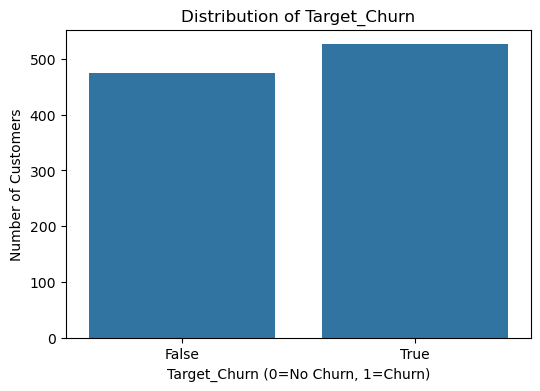

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_column_name, data=df)
plt.title(f'Distribution of {target_column_name}')
plt.xlabel(f'{target_column_name} (0=No Churn, 1=Churn)')
plt.ylabel('Number of Customers')
plt.show()

In [11]:
# Separate features by type for EDA and preprocessing
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

In [12]:
# Remove 'Churn' from numerical features if it was included
if target_column_name in numerical_features:
    numerical_features.remove(target_column_name)

print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")


Numerical Features: ['Age', 'Annual_Income', 'Total_Spend', 'Years_as_Customer', 'Num_of_Purchases', 'Average_Transaction_Amount', 'Num_of_Returns', 'Num_of_Support_Contacts', 'Satisfaction_Score', 'Last_Purchase_Days_Ago']
Categorical Features: ['Gender', 'Promotion_Response']


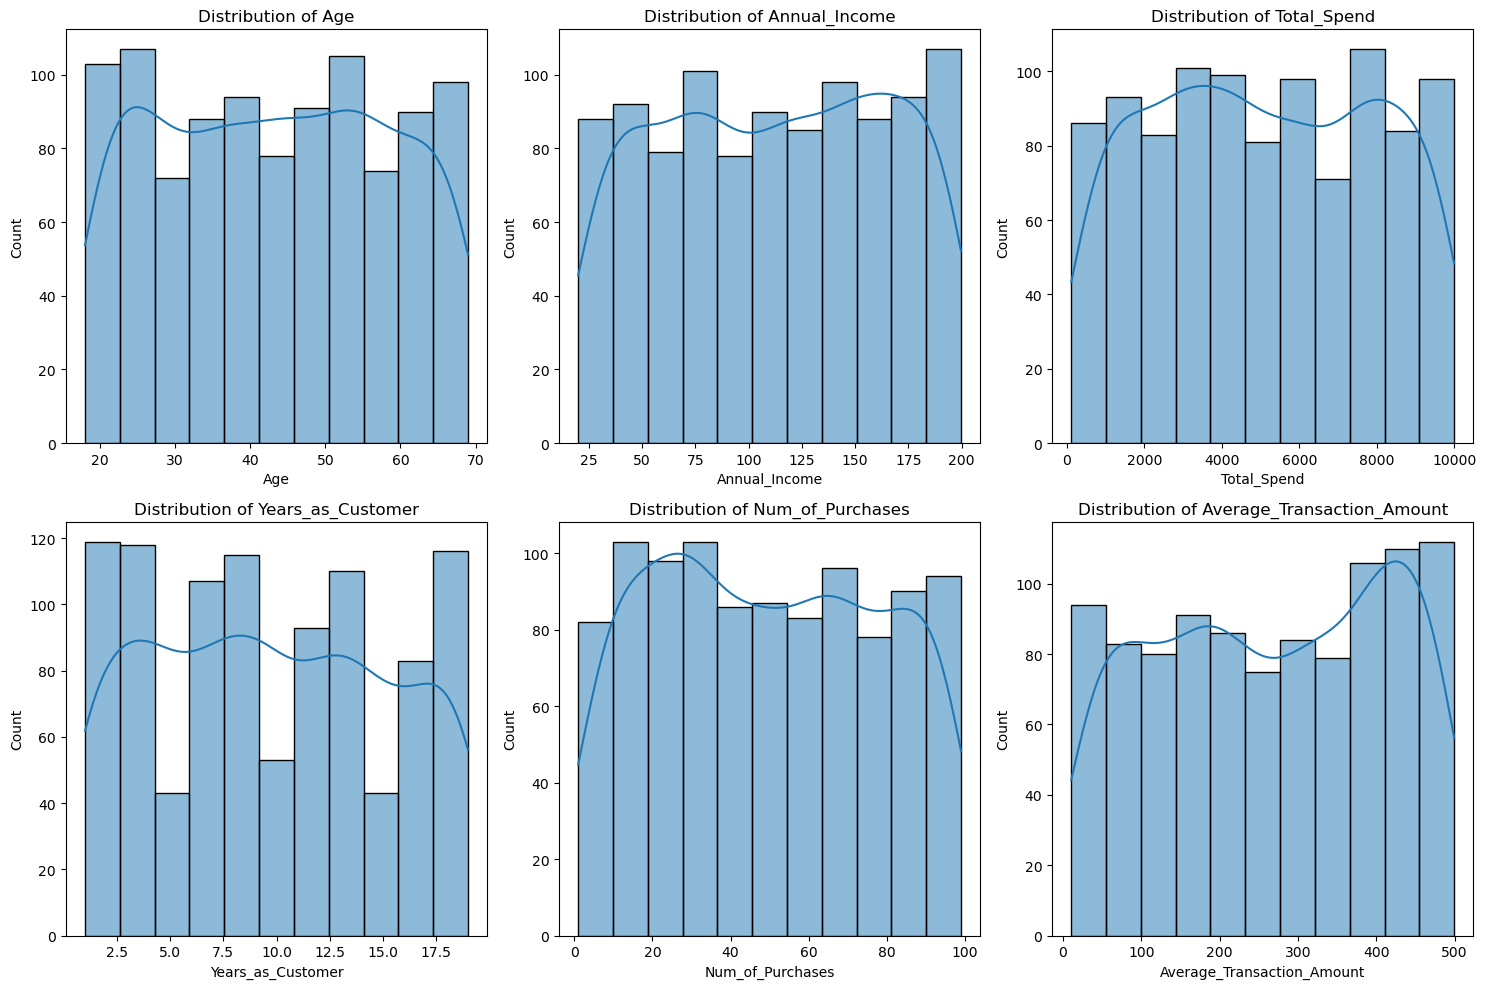

In [13]:
# Visualizing distributions of numerical features
plt.figure(figsize=(15, 10))
num_cols_to_plot = [col for col in numerical_features if col != target_column_name]
for i, col in enumerate(num_cols_to_plot):
    if i >= 6: break # Limit plots for clarity if many numerical features
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

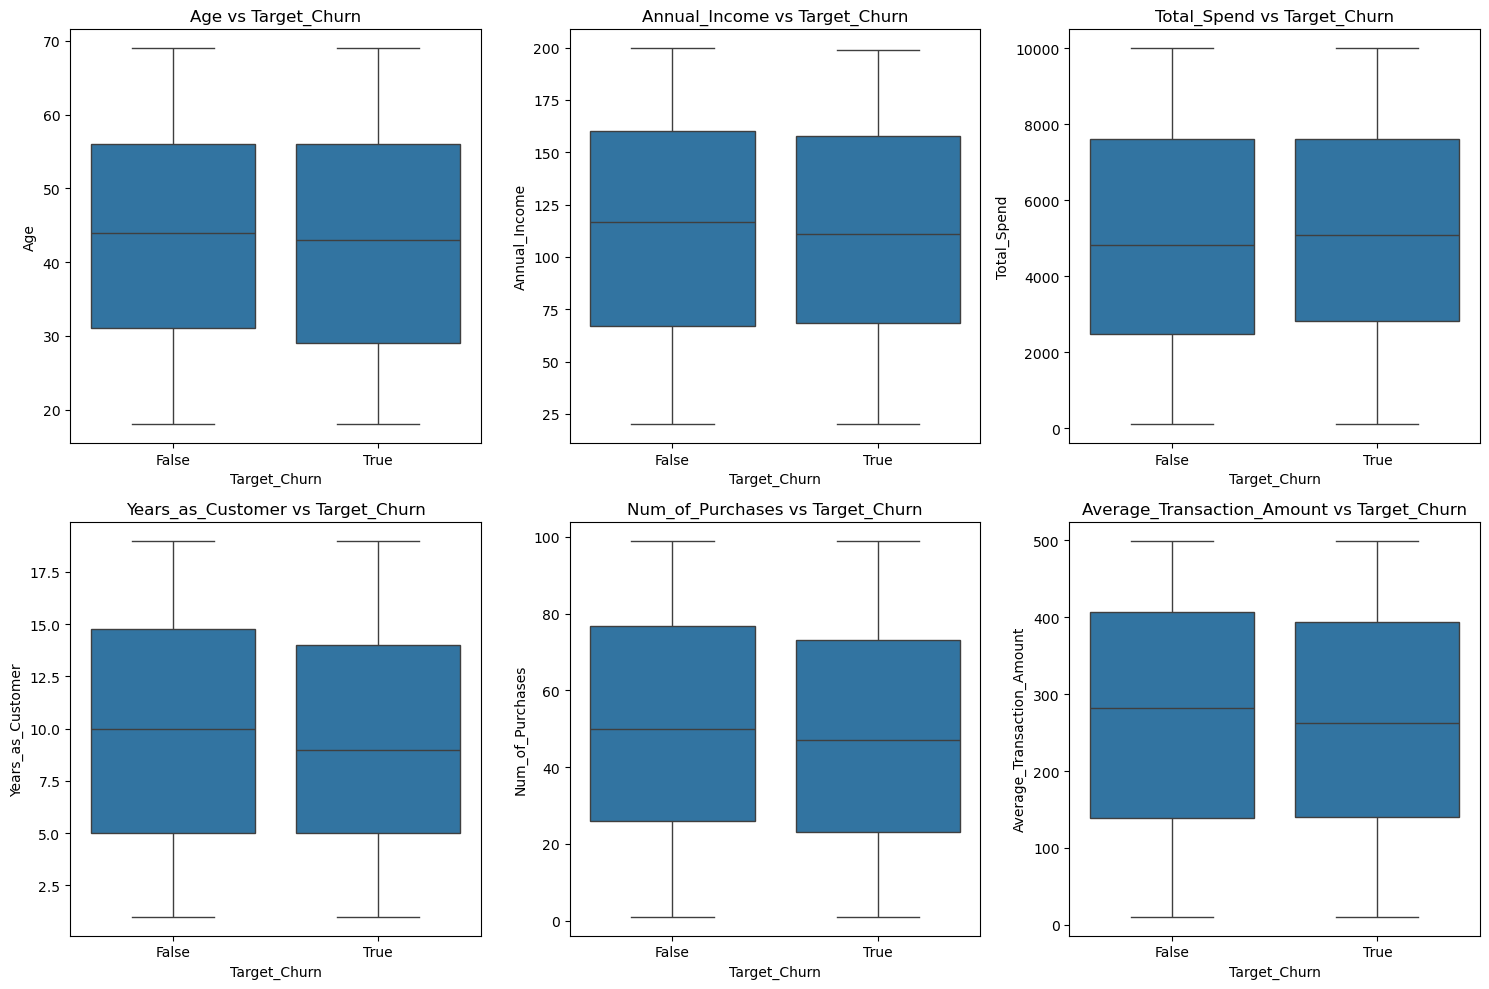

In [14]:
# Visualizing numerical features vs Churn
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols_to_plot):
    if i >= 6: break # Limit plots for clarity if many numerical features
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=target_column_name, y=col, data=df)
    plt.title(f'{col} vs {target_column_name}')
plt.tight_layout()
plt.show()

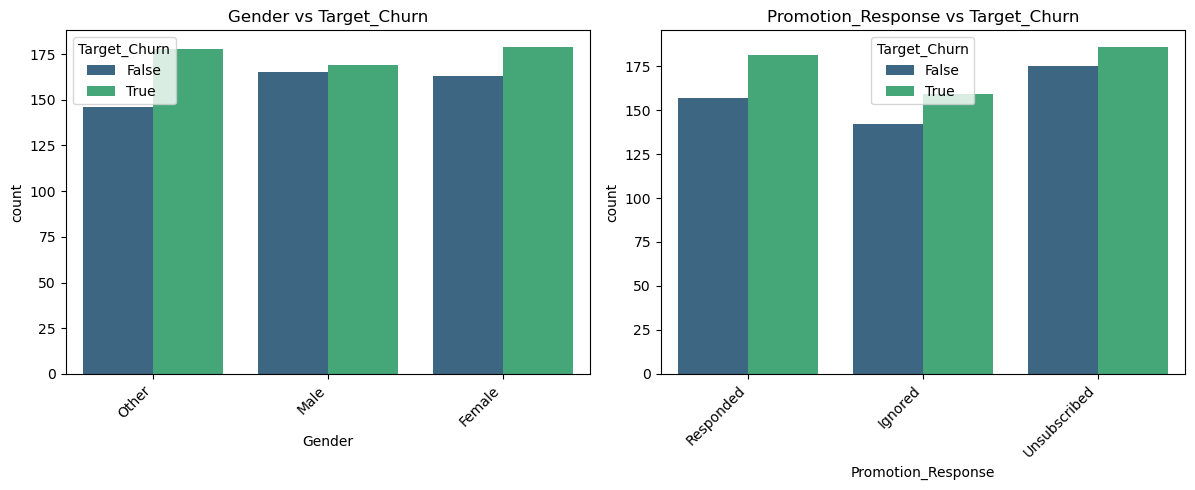

In [15]:
# Visualizing categorical features vs Churn
plt.figure(figsize=(18, max(5, len(categorical_features) * 2))) # Adjust figure height dynamically
for i, col in enumerate(categorical_features):
    plt.subplot(int(np.ceil(len(categorical_features)/3)), 3, i + 1)
    sns.countplot(x=col, hue=target_column_name, data=df, palette='viridis')
    plt.title(f'{col} vs {target_column_name}')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

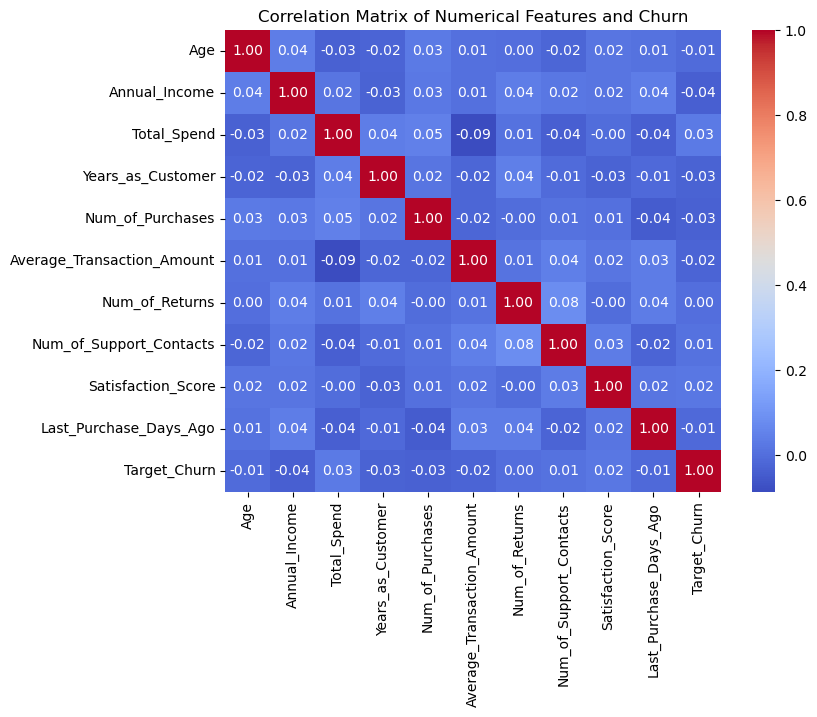

In [16]:
# Correlation Heatmap for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_features + [target_column_name]].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Churn')
plt.show()

In [17]:
# Feature Engineering Examples (adapt as needed for your specific dataset)
# Example: Creating RFM segments if not already present (highly relevant for retail)
# This assumes you might have transactional data from which to derive R, F, M.
# If your dataset is already aggregated, you might just use existing columns like 'DaysSinceLastPurchase' (Recency).
# Example: Creating 'SpendingCategory' from 'TotalSpend'
if 'TotalSpend' in df.columns:
    bins_spend = [0, 50, 200, 500, np.inf]
    labels_spend = ['Low Spender', 'Medium Spender', 'High Spender', 'Very High Spender']
    df['SpendingCategory'] = pd.cut(df['TotalSpend'], bins=bins_spend, labels=labels_spend, right=False)
    if 'SpendingCategory' not in categorical_features:
        categorical_features.append('SpendingCategory')

# Update categorical features list after feature engineering
categorical_features = df.select_dtypes(include='object').columns.tolist()
print(f"\nCategorical Features after engineering: {categorical_features}")


Categorical Features after engineering: ['Gender', 'Promotion_Response']


In [18]:
# Define features (X) and target (y)
X = df.drop(target_column_name, axis=1)
y = df[target_column_name]

In [19]:
# Identify column types again, as Feature Engineering might have added new ones
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Features for preprocessing:")
print(f"Numerical: {numerical_cols}")
print(f"Categorical: {categorical_cols}")

Features for preprocessing:
Numerical: ['Age', 'Annual_Income', 'Total_Spend', 'Years_as_Customer', 'Num_of_Purchases', 'Average_Transaction_Amount', 'Num_of_Returns', 'Num_of_Support_Contacts', 'Satisfaction_Score', 'Last_Purchase_Days_Ago']
Categorical: ['Gender', 'Promotion_Response']


In [20]:
# Preprocessing Pipelines
# Numerical Transformer: Impute (if any remain) and Scale
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [21]:
# Categorical Transformer: One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # handle_unknown='ignore' for unseen categories in test set
])

In [22]:
# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough' # Keep other columns not specified (if any)
)

In [23]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (800, 13)
Shape of X_test: (200, 13)
Shape of y_train: (800,)
Shape of y_test: (200,)


In [25]:
# ## 4. Model Selection & Implementation
# We will train several classification models, including baseline models and advanced ensemble methods. Given the class imbalance, we will integrate `SMOTE` into our pipelines for models that benefit from it (like Logistic Regression, SVMs, and some tree-based models if not inherently handling imbalance). For tree-based models like LightGBM and XGBoost, `scale_pos_weight` is often a better approach.

In [26]:
# Function to evaluate models
def evaluate_model(model, X_test_processed, y_test, model_name="Model"):
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    print(f"\n--- {model_name} Evaluation ---")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
     
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
# Calculate class weight for imbalanced datasets
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"\nScale Pos Weight for imbalanced data: {scale_pos_weight:.2f}")


Scale Pos Weight for imbalanced data: 0.90



--- Training Logistic Regression ---

--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

       False       0.45      0.46      0.46        95
        True       0.50      0.49      0.49       105

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.48      0.47      0.48       200

Accuracy: 0.4750
Precision: 0.5000
Recall: 0.4857
F1-Score: 0.4928
ROC-AUC Score: 0.4579


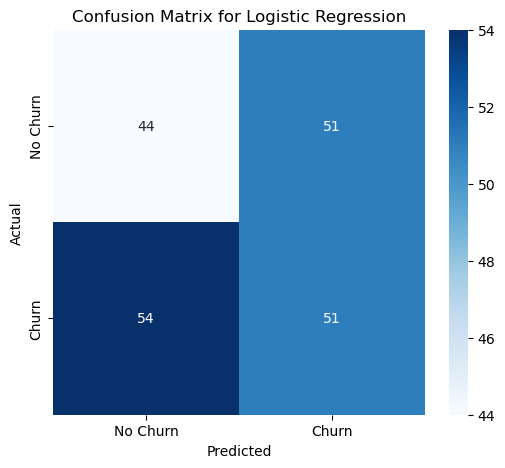

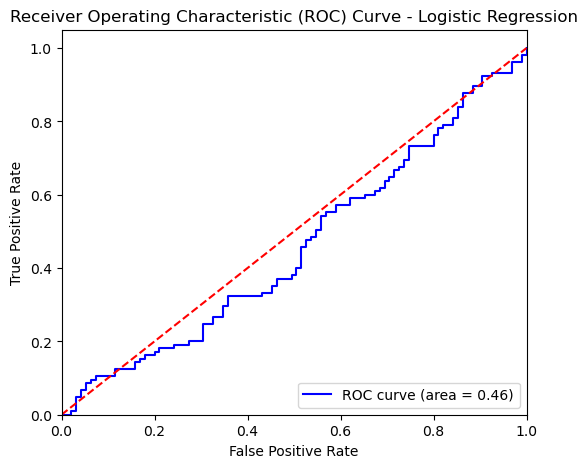

In [28]:
# --- Models ---

# 1. Logistic Regression (with SMOTE)
print("\n--- Training Logistic Regression ---")
logistic_model = ImbPipeline(steps=[('preprocessor', preprocessor),
                                    ('smote', SMOTE(random_state=42)),
                                    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')) # 'balanced' or custom weights
                                   ])
logistic_model.fit(X_train, y_train)
evaluate_model(logistic_model, X_test, y_test, "Logistic Regression")


--- Training Decision Tree Classifier ---

--- Decision Tree Evaluation ---
              precision    recall  f1-score   support

       False       0.52      0.48      0.50        95
        True       0.56      0.59      0.57       105

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200

Accuracy: 0.5400
Precision: 0.5586
Recall: 0.5905
F1-Score: 0.5741
ROC-AUC Score: 0.5373


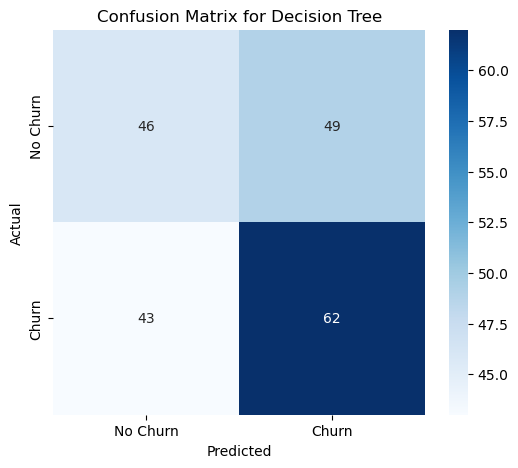

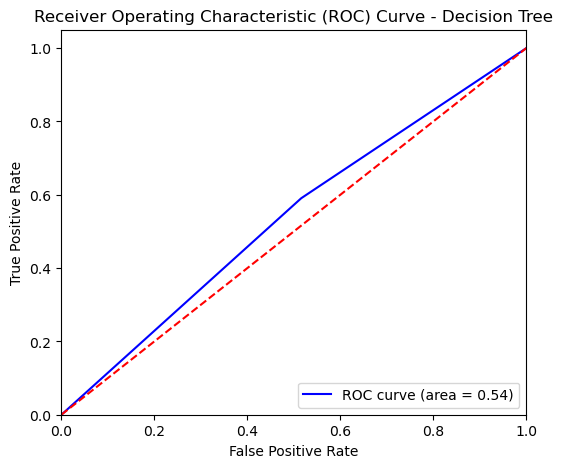

In [29]:
# 2. Decision Tree Classifier
print("\n--- Training Decision Tree Classifier ---")
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
                          ])
dt_model.fit(X_train, y_train)
evaluate_model(dt_model, X_test, y_test, "Decision Tree")


--- Training Random Forest Classifier ---

--- Random Forest Evaluation ---
              precision    recall  f1-score   support

       False       0.42      0.35      0.38        95
        True       0.49      0.56      0.52       105

    accuracy                           0.46       200
   macro avg       0.45      0.45      0.45       200
weighted avg       0.45      0.46      0.45       200

Accuracy: 0.4600
Precision: 0.4876
Recall: 0.5619
F1-Score: 0.5221
ROC-AUC Score: 0.4977


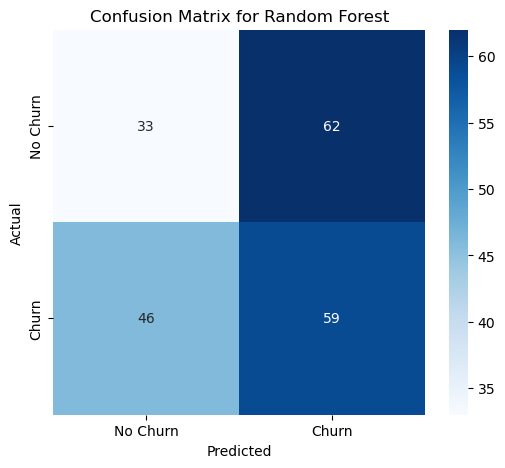

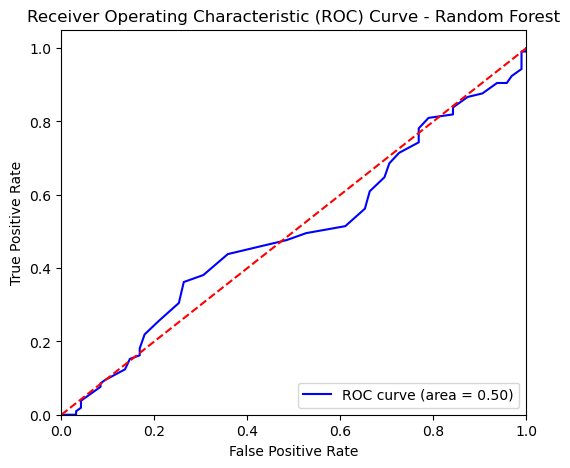

In [30]:
# 3. Random Forest Classifier
print("\n--- Training Random Forest Classifier ---")
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
                          ])
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")


--- Training XGBoost Classifier ---

--- XGBoost Evaluation ---
              precision    recall  f1-score   support

       False       0.44      0.44      0.44        95
        True       0.50      0.50      0.50       105

    accuracy                           0.47       200
   macro avg       0.47      0.47      0.47       200
weighted avg       0.47      0.47      0.47       200

Accuracy: 0.4700
Precision: 0.4952
Recall: 0.4952
F1-Score: 0.4952
ROC-AUC Score: 0.4794


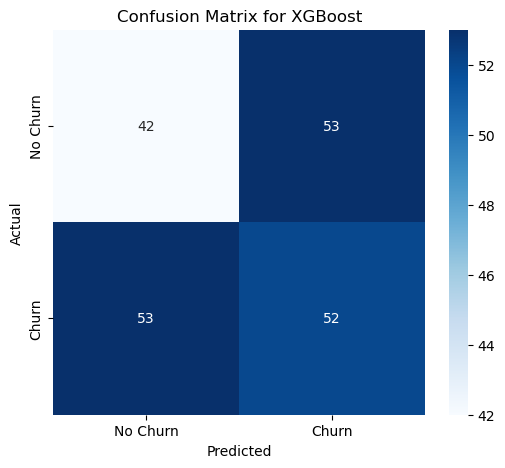

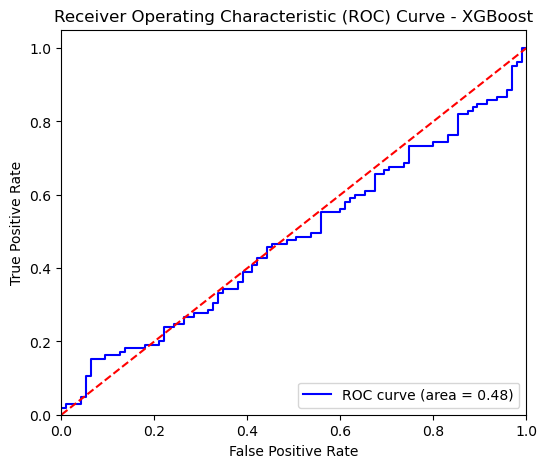

In [31]:
# 4. XGBoost Classifier
print("\n--- Training XGBoost Classifier ---")
# XGBoost can handle categorical features natively if encoded with integers, or you can one-hot encode.
# For simplicity, we keep the ColumnTransformer for consistency.
# Use scale_pos_weight for imbalance
xgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False,
                                                             eval_metric='logloss',
                                                             scale_pos_weight=scale_pos_weight)) # Handles imbalance
                           ])
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")


--- Training LightGBM Classifier ---
[LightGBM] [Info] Number of positive: 421, number of negative: 379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1226
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.526250 -> initscore=0.105097
[LightGBM] [Info] Start training from score 0.105097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

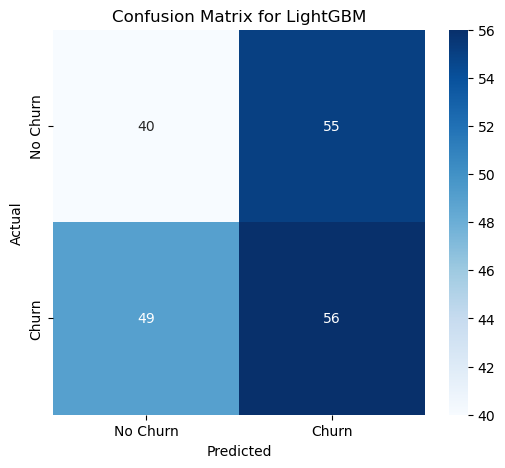

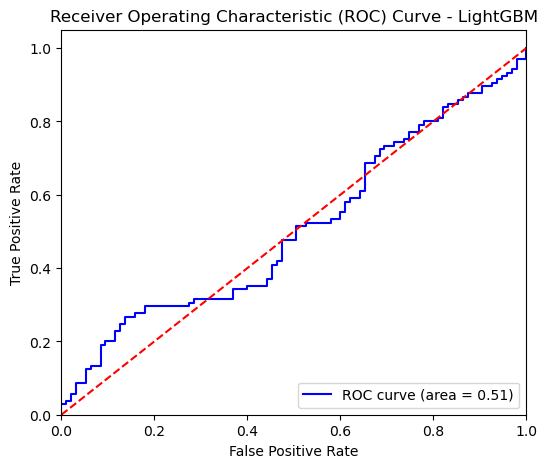

In [32]:
# 5. LightGBM Classifier
print("\n--- Training LightGBM Classifier ---")
# LightGBM also handles categorical features well, but we'll use one-hot encoding for consistency.
lgb_model = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', lgb.LGBMClassifier(random_state=42,
                                                               is_unbalance=True, # Alternative: scale_pos_weight
                                                               # scale_pos_weight=scale_pos_weight # Use this or is_unbalance
                                                              ))
                            ])
lgb_model.fit(X_train, y_train)
evaluate_model(lgb_model, X_test, y_test, "LightGBM")

In [33]:
# Get feature names after one-hot encoding for preprocessing
# This requires fitting the preprocessor separately to get transformed column names
preprocessor.fit(X_train)
ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names_transformed = numerical_cols + list(ohe_feature_names)

In [34]:
# Function to display feature importances
def plot_feature_importance(model, feature_names_transformed, model_name="Model"):
    importances = None
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'): # For Logistic Regression
        # For Logistic Regression, coefficients indicate importance, but need to match features
        # The number of coefficients should match the number of transformed features
        if len(model.coef_[0]) == len(feature_names_transformed):
            importances = np.abs(model.coef_[0]) # Take absolute value for importance
        else:
            print(f"Mismatch in coefficient length for {model_name}. Skipping feature importance plot.")
            return
    else:
        print(f"Feature importance not available for {model_name}")
        return

    # Ensure importances and feature_names_transformed have the same length
    if importances is None or len(importances) != len(feature_names_transformed):
        print(f"Error: Mismatch between number of features and importance values for {model_name}.")
        print(f"Expected {len(feature_names_transformed)} features, got {len(importances) if importances is not None else 'None'} importances.")
        return

    feature_importance_df = pd.DataFrame({'feature': feature_names_transformed, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, min(len(feature_importance_df) * 0.3 + 2, 15))) # Adjust height dynamically, max 15
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Top 20 features
    plt.title(f'Top 20 Feature Importance - {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [35]:
# Get the classifier step from the pipeline for feature importance
rf_classifier = rf_model.named_steps['classifier']
xgb_classifier = xgb_model.named_steps['classifier']
lgb_classifier = lgb_model.named_steps['classifier']
logistic_classifier = logistic_model.named_steps['classifier']

In [36]:
# Plot feature importance for Random Forest (after preprocessing)
print("\n--- Feature Importance for Random Forest ---")
plot_feature_importance(rf_classifier, all_feature_names_transformed, "Random Forest")


--- Feature Importance for Random Forest ---
Error: Mismatch between number of features and importance values for Random Forest.
Expected 16 features, got 17 importances.


In [37]:
# Plot feature importance for XGBoost
print("\n--- Feature Importance for XGBoost ---")
plot_feature_importance(xgb_classifier, all_feature_names_transformed, "XGBoost")


--- Feature Importance for XGBoost ---
Error: Mismatch between number of features and importance values for XGBoost.
Expected 16 features, got 17 importances.


In [38]:
# Plot feature importance for LightGBM
print("\n--- Feature Importance for LightGBM ---")
plot_feature_importance(lgb_classifier, all_feature_names_transformed, "LightGBM")


--- Feature Importance for LightGBM ---
Error: Mismatch between number of features and importance values for LightGBM.
Expected 16 features, got 17 importances.


In [39]:
# Plot feature importance for Logistic Regression (coefficients as importance)
print("\n--- Feature Importance (Coefficients) for Logistic Regression ---")
plot_feature_importance(logistic_classifier, all_feature_names_transformed, "Logistic Regression")


--- Feature Importance (Coefficients) for Logistic Regression ---
Mismatch in coefficient length for Logistic Regression. Skipping feature importance plot.


In [40]:
# Let's optimize the threshold for the LightGBM model as an example, as it often performs well.
# Get predicted probabilities on the test set
y_pred_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# Explore different thresholds
thresholds = np.linspace(0, 1, 100) # 100 thresholds between 0 and 1
precision_scores = []
recall_scores = []
f1_scores = []

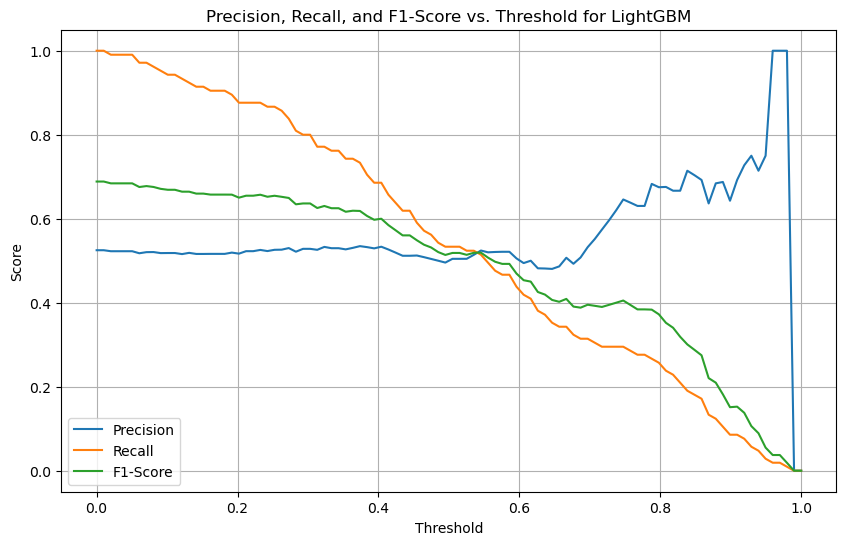

In [41]:
for t in thresholds:
    y_pred_tuned = (y_pred_proba_lgb >= t).astype(int)
    # Use zero_division=0 to avoid warnings for cases with no true positives or predicted positives
    precision_scores.append(precision_score(y_test, y_pred_tuned, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_tuned, zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_tuned, zero_division=0))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score vs. Threshold for LightGBM')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Find the threshold that maximizes F1-score (or another metric based on business need)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold (max F1-Score): {optimal_threshold:.4f}")

Optimal Threshold (max F1-Score): 0.0000


In [43]:
# Re-evaluate LightGBM with the optimal threshold
y_pred_optimal_lgb = (y_pred_proba_lgb >= optimal_threshold).astype(int)

In [44]:
print(f"\n--- LightGBM Evaluation with Optimal Threshold ({optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_optimal_lgb))
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimal_lgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal_lgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal_lgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimal_lgb):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lgb):.4f}") # ROC-AUC doesn't change with threshold


--- LightGBM Evaluation with Optimal Threshold (0.0000) ---
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        95
        True       0.53      1.00      0.69       105

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200

Accuracy: 0.5250
Precision: 0.5250
Recall: 1.0000
F1-Score: 0.6885
ROC-AUC Score: 0.5085
